# Colab 환경에서만 실행
#### tensorflow 2 버전을 불러들이기 위한 코드
#### google drive 와 연결(mount)하기 위한 코드

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [0]:
# driver mount
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Module Import

In [0]:
import os
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
# from PIL import Image, ImageDraw
print('tf version :',tf.__version__)
print('tf gpu available :',tf.test.is_gpu_available())

tf version : 2.0.0
tf gpu available : True


# data load 

#### x_train.npy : (26640, 64, 64)
#### y_train.npy : (26640,) 
#### num2class.pickle : {label:class name} #340

In [0]:
#Load preprocessed quick_draw_data at my google drive   
root = 'drive/My Drive/quick_draw_text2image'
path = '/'

x_train = np.load(root+path+'x_train.npy')
y_train = np.load(root+path+'y_train.npy')
print('train data & labels shape:',x_train.shape, y_train.shape)

with open(root+path+'nums2class.pickle', 'rb') as f:
    num2class = pickle.load(f)
print('number of classes :',len(num2class))

train data & labels shape: (26640, 64, 64) (26640,)
number of classes : 340


# data visualize

Text(0.5, 0, 'airplane')

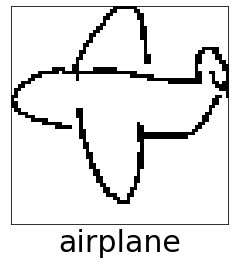

In [0]:
plt.imshow(x_train[3], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel(num2class[y_train[3]],size=30)

# Data Preprocess

In [0]:
real_images = x_train[..., tf.newaxis] #(26640, 64, 64, 1)

def label2noise_input(x):
    text = np.zeros(340,dtype = 'float')
    text[x]=1.0
    noise = np.random.normal(size=(100,))
    return tf.concat([text,noise],axis=0)

generator_inputs= list(map(label2noise_input,y_train)) # 
# generator_inputs= np.array([label2noise_input(y) for y in y_train])

labels = y_train[:]

print('real_images shape :',real_images.shape)
print('generator_inputs :',len(generator_inputs),len(generator_inputs[0]))
print('labels shape :',labels.shape)

real_images shape : (26640, 64, 64, 1)
generator_inputs : 26640 440
labels shape : (26640,)


In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((real_images, generator_inputs, labels)).shuffle(10000).batch(64)

# Generator Model

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Embedding(input_dim=440, output_dim=100))
    model.add(layers.Dense(16*16*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model

In [0]:
generator = make_generator_model()
# tf.keras.utils.plot_model(generator)

In [2]:
test_gen_input = generator_inputs[0][tf.newaxis, ...]
test_gen_input.shape
gen_img = generator(test_gen_input)

test_gen_input.shape

NameError: ignored

# Discriminator Model

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(341))

    return model

In [0]:
discriminator = make_discriminator_model()
# tf.keras.utils.plot_model(disscriminator)

# loss

In [0]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss(labels, real_output)
    fake_loss = loss(tf.ones(fake_output.shape[0],)*341 #(batch_size, )
                     , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output,labels):
    return loss(labels, fake_output)

# Optimizer : Adam

In [0]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

# Check point

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Train definition

In [0]:
@tf.function
def train_step(images, generator_input, labels):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(generator_input, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output, labels)
        disc_loss = discriminator_loss(real_output, fake_output, labels)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
test_input = generator_inputs[0][tf.newaxis,...]
test_img_list =[tf.squeeze(generator(test_input))]

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, generator_inputs_batch, labels_batch in dataset:
            train_step(image_batch, generator_inputs_batch, labels_batch)

        if (epoch +1) % 5 ==0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
        # for gen img checking per epoch
        gen_img = generator(test_input)
        test_img_list.append(tf.squeeze(gen_img))

    print('Train Done')

# Train

In [0]:
train(train_ds,1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time for epoch 1 is 55.03682088851929 sec
Train Done


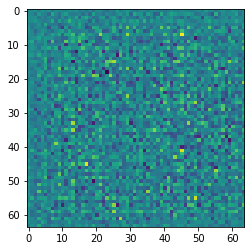

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


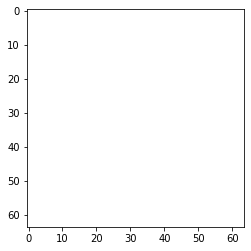

In [0]:
for img in test_img_list:
    plt.imshow(img)
    plt.show()

In [0]:
for i in range(64):
    print(test_img_list[1][i].numpy())

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan na